### Changes from Transformer
- Positional Encoding -> Positional Embedding
- 인코더 관련 모듈 삭제


In [367]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

## Attention

### Scaled dot-product Attention

In [368]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output


### Multi-head Attention

In [369]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)
        return outputs
    
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

## Masking

In [370]:
# 0인 값은 1로, 그외 값은 0으로
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [371]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [372]:
# example
create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]]))

<tf.Tensor: shape=(1, 1, 5, 5), dtype=float32, numpy=
array([[[[0., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]]], dtype=float32)>

In [373]:
# example: 0 is padding
create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]]))

<tf.Tensor: shape=(1, 1, 5, 5), dtype=float32, numpy=
array([[[[1., 1., 1., 1., 1.],
         [1., 0., 1., 1., 1.],
         [1., 0., 0., 1., 1.],
         [1., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0.]]]], dtype=float32)>

## GPT

### Positional Embedding

In [374]:
#####################################
######## Encoder -> Embedder ########
#####################################
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, max_len, d_model, name="pos_embedding"):
        super(PositionalEmbedding, self).__init__()
        self.max_len = max_len
        self.d_model = d_model
        self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_len, output_dim=d_model, name=name)

    def call(self, inputs):
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        positions = self.pos_embedding(positions)
        return inputs + positions

### Decoder

In [375]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")

    self_attention = MultiHeadAttention(d_model, num_heads, name="attention_1")(
        inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        }
    )
    self_attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(self_attention + inputs)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(self_attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + self_attention)

    return tf.keras.Model(
        inputs=[inputs, look_ahead_mask],
        outputs=outputs,
        name=name)

def decoder(vocab_size,
            seq_len,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model, name="word_embedding")(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 임베딩
    pos_embeddings = PositionalEmbedding(seq_len, d_model)(embeddings)
    
    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(pos_embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, look_ahead_mask])

    return tf.keras.Model(
      inputs=[inputs, look_ahead_mask],
      outputs=outputs,
      name=name)

In [376]:
##################################
######## 인코더 관련 모듈 삭제 ########
##################################
def GPT(vocab_size,
        seq_len,
        num_layers,
        units,
        d_model,
        num_heads,
        dropout,
        name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(inputs)

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        seq_len=seq_len,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, look_ahead_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)
    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

## Data

In [377]:
import pandas as pd

data_df = pd.read_csv("data/ChatbotData.csv")
data_df

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [378]:
q_max_words = data_df["Q"].apply(lambda x: len(x.split())).max()
a_max_words = data_df["A"].apply(lambda x: len(x.split())).max()

print(f"{q_max_words=}, {a_max_words=}")

q_max_words=15, a_max_words=21


In [379]:
data_df.isna().sum()

Q        0
A        0
label    0
dtype: int64

In [380]:
len(data_df["Q"].tolist())

11823

In [381]:
import re

def preprocess_sentence(sentence):
    sentence = sentence.strip()
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub('([ㄱ-ㅎㅏ-ㅣ]+)', '', sentence) # 한글 자음, 모음 제거
    sentence = re.sub('[^\w\s\n]', '', sentence) # 특수기호 제거
    sentence = sentence.strip()
    return sentence
    
def load_conversation(data_df):
    questions = data_df["Q"].tolist()
    answers = data_df["A"].tolist()
    
    questions = [preprocess_sentence(q) for q in questions]
    answers = [preprocess_sentence(a) for a in answers]
    
    return questions, answers

In [382]:
import tensorflow_datasets as tfds

questions, answers = load_conversation(data_df)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [383]:
START_TOKEN = tokenizer.vocab_size
END_TOKEN = tokenizer.vocab_size + 1
DELIMITER_TOKEN = tokenizer.vocab_size + 2

VOCAB_SIZE = tokenizer.vocab_size + 3


In [384]:
MAX_LENGTH = 80

def tokenize(questions, answers):
    tokenized_sentenses = []
    
    for q, a in zip(questions, answers):
        tokenized_sentenses.append(
            #############################
            ######## 입력 형태 변경 ########
            #############################
            [START_TOKEN] + tokenizer.encode(q) + [DELIMITER_TOKEN] + tokenizer.encode(a) + [END_TOKEN]
        )
        
    return keras.preprocessing.sequence.pad_sequences(tokenized_sentenses, maxlen=MAX_LENGTH, padding='post')

In [385]:
sentences_tokens = tokenize(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 문장 샘플 개수: {}'.format(len(sentences_tokens)))

단어장의 크기 : 8181
필터링 후의 문장 샘플 개수: 11823


In [386]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': sentences_tokens[:, :-1], # eos 토큰 제외
    },
    {
        'outputs': sentences_tokens[:, 1:] # sos 토큰 제외
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [387]:
for s in dataset.take(1):
    print(s)

({'inputs': <tf.Tensor: shape=(64, 79), dtype=int32, numpy=
array([[8178, 4555,   25, ...,    0,    0,    0],
       [8178, 7571, 7954, ...,    0,    0,    0],
       [8178, 5012,  204, ...,    0,    0,    0],
       ...,
       [8178, 3947, 2299, ...,    0,    0,    0],
       [8178,    7,   38, ...,    0,    0,    0],
       [8178, 2444,  466, ...,    0,    0,    0]], dtype=int32)>}, {'outputs': <tf.Tensor: shape=(64, 79), dtype=int32, numpy=
array([[4555,   25,  375, ...,    0,    0,    0],
       [7571, 7954,  328, ...,    0,    0,    0],
       [5012,  204,   82, ...,    0,    0,    0],
       ...,
       [3947, 2299, 4041, ...,    0,    0,    0],
       [   7,   38,  219, ...,    0,    0,    0],
       [2444,  466,   61, ...,    0,    0,    0]], dtype=int32)>})


## Train

In [388]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = GPT(
    vocab_size=VOCAB_SIZE,
    seq_len=MAX_LENGTH,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
look_ahead_mask (Lambda)        (None, 1, None, None 0           inputs[0][0]                     
__________________________________________________________________________________________________
decoder (Functional)            (None, None, 256)    3169024     inputs[0][0]                     
                                                                 look_ahead_mask[0][0]            
__________________________________________________________________________________________________
outputs (Dense)                 (None, None, 8181)   2102517     decoder[0][0]          

In [389]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [390]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


Text(0.5, 0, 'Train Step')

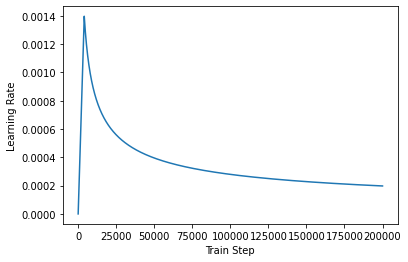

In [391]:
import matplotlib.pyplot as plt

sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [392]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [394]:
EPOCHS = 30

history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/30
185/185 [==============================] - 11s 61ms/step - loss: 1.2717 - accuracy: 0.0184
Epoch 2/30
185/185 [==============================] - 11s 62ms/step - loss: 1.1086 - accuracy: 0.0253
Epoch 3/30
185/185 [==============================] - 11s 61ms/step - loss: 1.0145 - accuracy: 0.0267
Epoch 4/30
185/185 [==============================] - 11s 61ms/step - loss: 0.9478 - accuracy: 0.0300
Epoch 5/30
185/185 [==============================] - 11s 61ms/step - loss: 0.8911 - accuracy: 0.0331
Epoch 6/30
185/185 [==============================] - 11s 61ms/step - loss: 0.8363 - accuracy: 0.0365
Epoch 7/30
185/185 [==============================] - 11s 61ms/step - loss: 0.7818 - accuracy: 0.0405
Epoch 8/30
185/185 [==============================] - 11s 61ms/step - loss: 0.7253 - accuracy: 0.0447
Epoch 9/30
185/185 [==============================] - 11s 61ms/step - loss: 0.6666 - accuracy: 0.0492
Epoch 10/30
185/185 [==============================] - 11s 61ms/step - loss: 0.606

## inference

In [395]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims([START_TOKEN] + tokenizer.encode(sentence) + [END_TOKEN], axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims([START_TOKEN], 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=sentence, training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [396]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])

    return predicted_sentence

In [397]:
import random

indexes = random.choices(range(len(questions)), k=20)

# 실제 답변과 모델 답변 비교
for i in indexes:
    question = questions[i]
    answer = answers[i]
    answer_pred = sentence_generation(question)
    print(f"[질문] {question} / [모델 답변] {answer_pred} / [실제 답변] {answer}")

[질문] 내가 많이 부족한가 / [모델 답변] 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고 보고  / [실제 답변] 잘하는 게 다른 거예요
[질문] 좋아하는 사람이 단톡에서 다른 남자한테 관심 있는 것 같이 보여요 / [모델 답변]                                                                                  / [실제 답변] 그렇게 느낀다면 조금씩 정리하는게 좋겠어요
[질문] 짝녀 고민 들어줘 / [모델 답변]  / [실제 답변] 들어드릴게요
[질문] 적당히를 몰라 / [모델 답변]                                                                                  / [실제 답변] 사람들이 중간을 몰라요
[질문] 썸남 목소리 듣고 싶어 / [모델 답변]  / [실제 답변] 지금 전화해보세요
[질문] 사랑할수록 행복해 / [모델 답변] 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무 너무  / [실제 답변] 행복한 사랑을 하고 있네요
[질문] 싸우면 어떻게 해결해 / [모델 답변] 보고 보고 